In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/methods/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

### this creates "active" calibration data! not the same as what's used to define the decoder!

## 30th percentile (> 0.5 std above mean), 1-99.5 percentile global

In [3]:
if sys.platform == "linux":
    ROOT_RAWDATA_PATH = Path("/home/spencer/motor-control/data/rawdata/")
    ROOT_METADATA_PATH = Path("/home/spencer/motor-control/data/metadata/")  
else:   
    ROOT_RAWDATA_PATH = Path("/Users/spencer/motor-control/data/rawdata/")
    ROOT_METADATA_PATH = Path("/Users/spencer/motor-control/data/metadata/")

def load_calibration_stack(subject):
    # session, trial, channel, time
    stack = np.empty(shape=(2,32,64,2400))
    stack[:] = np.nan
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_calibration_emg_filenames("emg_olympics", subject.name, session_name)
        for trial_idx, filename in enumerate(filenames):
            e = analysis.load_calibration_emg(filename)
            assert e.shape[1] == 64, e.shape
            assert e.shape[0] > e.shape[1], e.shape
            ef = emg.filter_emg(e,subject.variance)[:-1]
            stack[session_idx, trial_idx, :, :ef.shape[0]] = ef.T
    return np.array(stack)

def compute_cutoffs(subject_stack):
    # global cutoffs
    assert subject_stack.shape[2] == 64, subject_stack.shape
    samples = analysis.remove_nan_rows(subject_stack.transpose(0,1,3,2).reshape(-1,64))
    lognorms = np.log(np.linalg.norm(samples,axis=1))
    return (np.percentile(lognorms,1), np.percentile(lognorms,99.5))

def find_cutoff_mask(signal,cutoffs):
    # use this with single trials!
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    assert len(cutoffs) == 2
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mask = (cutoffs[0] < log_norm) * (log_norm < cutoffs[1])
    return np.arange(signal.shape[0])[mask]

def find_within_trial_mask(signal):
    # within trial values -- 30th percentile of log X
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mean_log_norm = np.mean(log_norm)
    std_log_norm = np.std(log_norm)
    # assuming large samples and rv being lognormal, this is roughly the 30th percentile
    mask = log_norm > (mean_log_norm - 0.5*std_log_norm)
    return np.arange(signal.shape[0])[mask]

def find_trial_filter_indices(signal, cutoffs):
    # combine filters
    assert signal.shape[1] == 64, signal.shape
    assert signal.shape[0] > signal.shape[1], signal.shape
    return np.array([i for i in range(signal.shape[0]) if ((i in find_within_trial_mask(signal)) and (i in find_cutoff_mask(signal, cutoffs)))])

# load and filter the data
def filter_subject_calibration_stack(subject_stack):
    assert subject_stack.shape[2] == 64
    assert len(subject_stack.shape) == 4
    # session, trial, channel, time
    stack = np.zeros_like(subject_stack)
    stack[:] = np.nan
    cutoffs = compute_cutoffs(subject_stack)
    for session_idx, session_trials in enumerate(subject_stack):
        for trial_idx, e in enumerate(session_trials):
            assert e.shape[0] == 64, e.shape
            assert e.shape[1] > e.shape[0], e.shape
            e_without_nans = analysis.remove_nan_rows(e.T)
            if e_without_nans.shape[0] < e_without_nans.shape[1]:
                print(f"Empty trial: {session_idx,trial_idx}")
            else:
                indices = find_trial_filter_indices(e_without_nans,cutoffs)
                e = e[:,indices]
                # stuff this into stack array
                stack[session_idx, trial_idx, :, :e.shape[1]] = e
    return stack


## build calibration stacks

In [7]:
stacks = []
raw_stacks = []
for subject_idx, subject in enumerate(subjects):
    raw_stack = load_calibration_stack(subject)
    filtered_stack = filter_subject_calibration_stack(raw_stack)
    stacks += [filtered_stack]
    raw_stacks += [raw_stack]
stacks = np.array(stacks)
raw_stacks = np.array(raw_stacks)

Empty trial: (1, 1)
Empty trial: (1, 2)
Empty trial: (1, 3)
Empty trial: (1, 4)
Empty trial: (1, 5)
Empty trial: (1, 6)
Empty trial: (1, 7)
Empty trial: (1, 8)
Empty trial: (1, 9)
Empty trial: (1, 10)
Empty trial: (1, 11)
Empty trial: (1, 12)
Empty trial: (1, 13)
Empty trial: (1, 14)
Empty trial: (1, 15)
Empty trial: (1, 16)
Empty trial: (1, 17)
Empty trial: (1, 18)
Empty trial: (1, 19)
Empty trial: (1, 20)
Empty trial: (1, 21)
Empty trial: (1, 22)
Empty trial: (1, 23)
Empty trial: (1, 24)
Empty trial: (1, 25)
Empty trial: (1, 26)
Empty trial: (1, 27)
Empty trial: (1, 28)
Empty trial: (1, 29)
Empty trial: (1, 30)
Empty trial: (1, 31)


## confirm that trial data looks like "hand" filtered

In [5]:
session_names = ["session_0","session_1"]
session_idx = 0
subject_idx = 0
trial_idx = 0
channel = 10

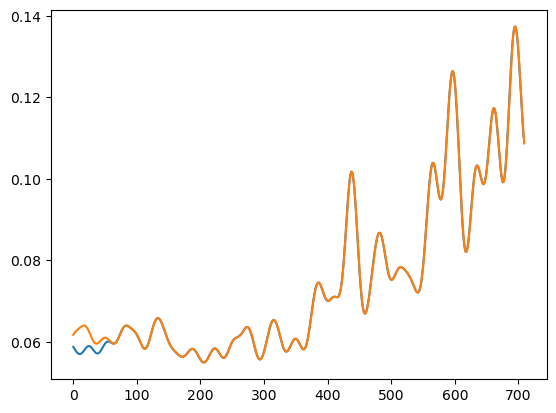

In [6]:
trial = subjects[subject_idx].tasks["center_hold"].sorted_sessions()[session_idx].sorted_trials()[trial_idx]
ef = trial.get_filtered_emg()
er = trial.get_raw_emg()[:,:64]
ch = 12
e_new_filter = emg.filter_emg(er,subjects[subject_idx].variance)

plt.plot(ef.T[ch])
plt.plot(e_new_filter.T[ch])

## compare "bar" data to "hand" filtered data

Bar data is 60Hz -- this is 1/3 of the samples of the filtered (200Hz) data

In [24]:
cutoffs = compute_cutoffs(raw_stack)

(64, 721)
(64, 2401)
(64, 2400)


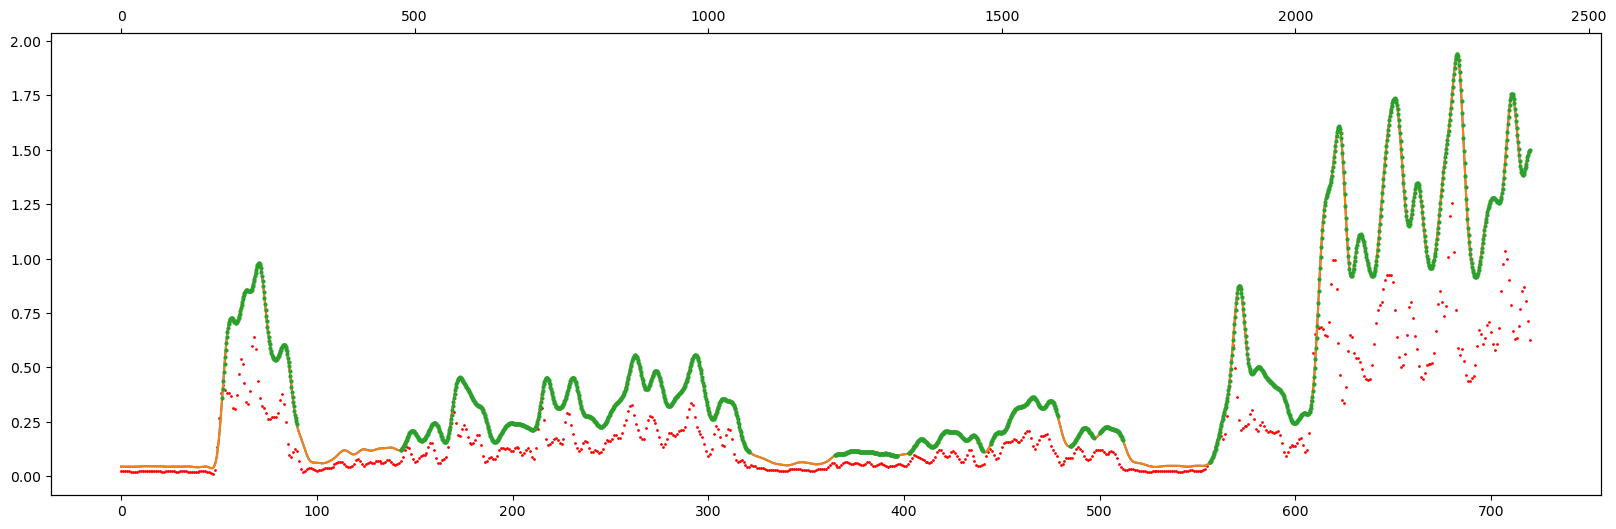

In [39]:
bar_filenames = analysis.get_calibration_bar_filenames("emg_olympics", subjects[subject_idx].name, session_name=session_names[session_idx])
bar = analysis.load_calibration_bar(bar_filenames[trial_idx]).T
print(bar.shape)
plt.figure(figsize=(20,6))
plt.plot(bar[channel],"ro",markersize=1)

plt.twiny()
# plt.twinx()
# load and filter one trial manually
emg_filenames = analysis.get_calibration_emg_filenames("emg_olympics", subjects[subject_idx].name, session_name=session_names[session_idx])
emg_signal = analysis.load_calibration_emg(emg_filenames[trial_idx])
filtered_emg = emg.filter_emg(emg_signal,subjects[subject_idx].variance).T
print(filtered_emg.shape)
plt.plot(filtered_emg[channel])

# plt.twiny()
# plt.twinx()
raw_emg = raw_stacks[subject_idx,session_idx,trial_idx]
plt.plot(raw_emg[channel])
print(raw_emg.shape)

# k = 0
# for i, h in enumerate(raw_emg[channel].T):
#     if np.random.uniform(0,1) < 0.3:
#         plt.plot(k,h,"bo",markersize=1)
#         k += 1
        

indices = find_trial_filter_indices(raw_emg.T,cutoffs)
plt.plot(indices, raw_emg[channel,indices],"o",markersize=2)

## save the stacks

In [8]:
# # subject, session, trial, channel, time
# np.save("subject_filtered_calibration_stacks.npy",stacks)
# np.save("subject_raw_calibration_stacks.npy",raw_stacks)

## test loading the stacks

In [4]:
subject_raw_calibration_stacks = np.load("../subject_raw_calibration_stacks.npy")
print(subject_raw_calibration_stacks.shape)

subject_calibration_stacks = np.load("../subject_filtered_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

(46, 2, 32, 64, 2400)
(46, 2, 32, 64, 2400)


In [8]:
# test stepping through raw data
subject_idx = 27
subject = subjects[subject_idx]
raw_stack = subject_raw_calibration_stacks[subject_idx]
cutoffs = compute_cutoffs(raw_stack)
filtered_stack = subject_calibration_stacks[subject_idx]
session_idx = 1
trial_idx = 14
e = analysis.remove_nan_rows(raw_stack[session_idx,trial_idx,:,:].T)
indices = find_trial_filter_indices(e,cutoffs)

## inspect EMG signal

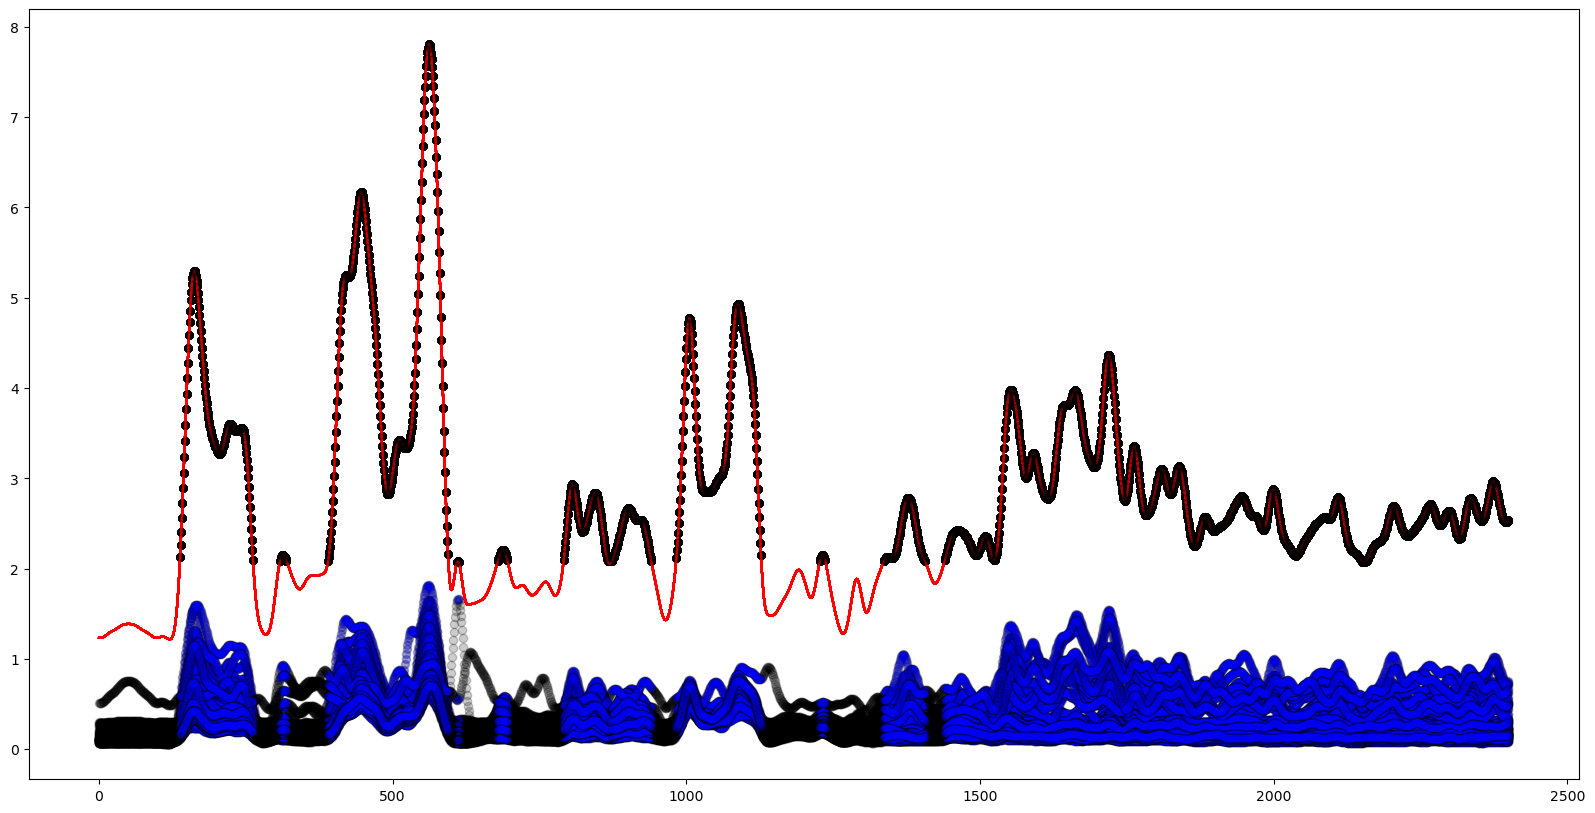

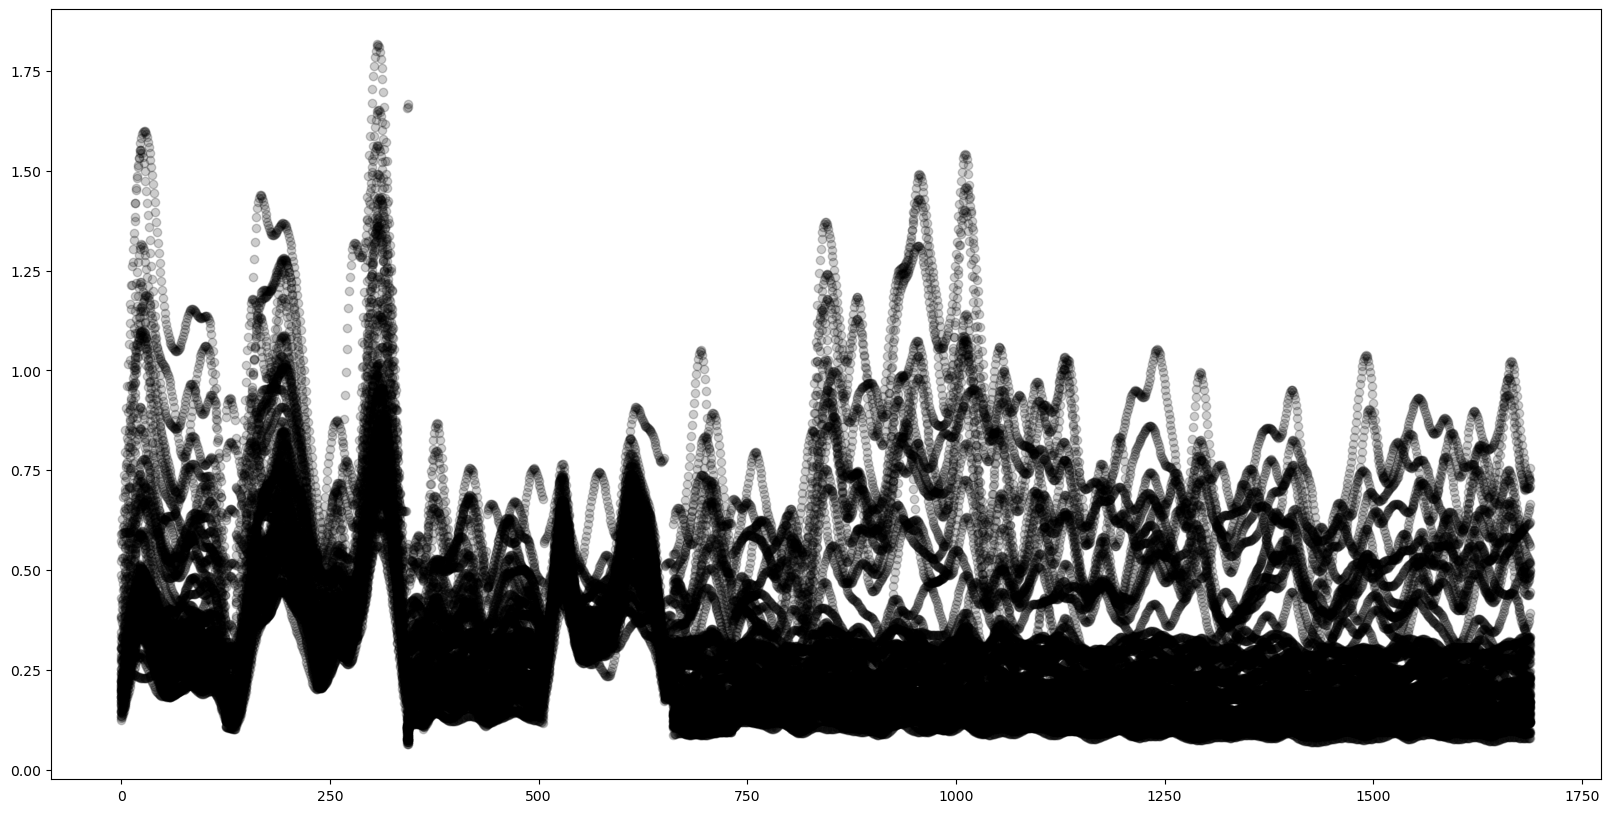

In [9]:
plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(e[:,ch],'ko',alpha=0.2)
    plt.plot(indices, e[indices,ch],'bo',alpha=0.2,markersize=5)
    plt.plot(np.linalg.norm(e,axis=1),"r",)
    plt.plot(indices,np.linalg.norm(e,axis=1)[indices],"ko",alpha=0.2,markersize=5)
plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(filtered_stack[session_idx,trial_idx,ch],'ko',alpha=0.2)

## inspect trajectory

(1689,)


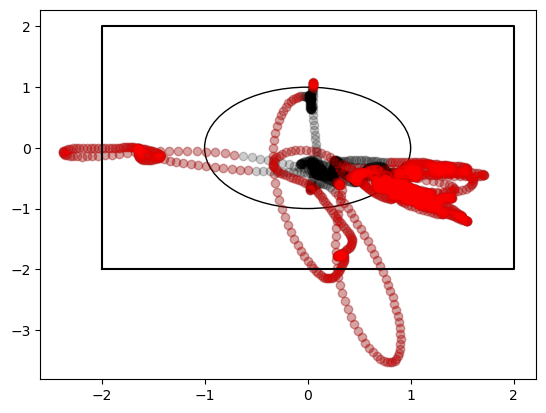

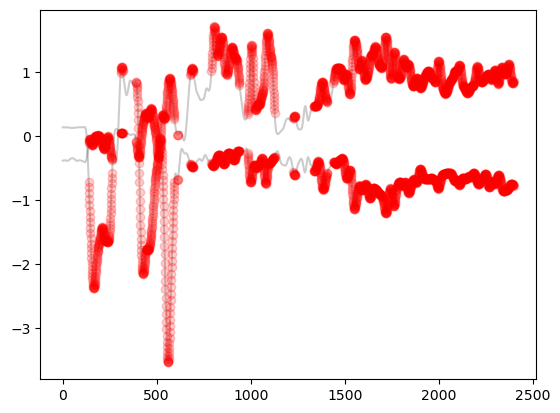

In [10]:
d = subject.decoder[-2:,:]
t = d @ e.T
print(indices.shape)
plt.figure()
plt.plot(t[0],t[1],"ko",alpha=0.2)
plt.plot(t[0,indices],t[1,indices],"ro",alpha=0.2)
l = 2
plt.plot([-l,-l,l,l,-l],[-l,l,l,-l,-l],'k')
c = plt.Circle([0,0],1,color="k",fill=None)
plt.gca().add_patch(c)

plt.figure()
plt.plot(t[0],'k',alpha=0.2)
plt.plot(t[1],'k',alpha=0.2)
plt.plot(indices,t[0,indices],'ro',alpha=0.2)
plt.plot(indices,t[1,indices],'ro',alpha=0.2)


## inspect histograms of signal norms

- raw sample norms
- filtered sample norms

- log transformed sample norms
- log transformed filtered sample norms


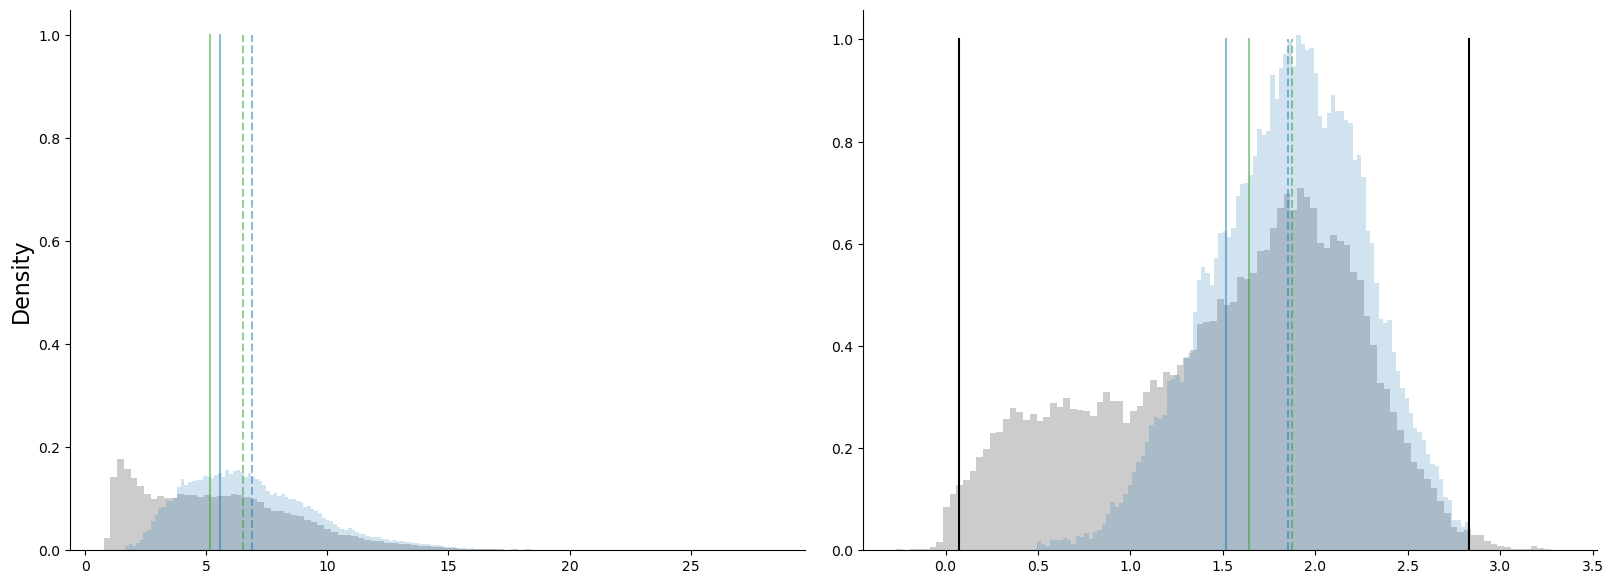

In [5]:
subject_idx = 1

raw_stack = subject_raw_calibration_stacks[subject_idx]
filtered_stack = subject_calibration_stacks[subject_idx]

cutoffs = compute_cutoffs(raw_stack)

fig, axes = plt.subplots(1,2,figsize=(16,6))
fig.tight_layout()

raw_samples = analysis.remove_nan_rows(raw_stack.transpose(0,1,3,2).reshape(-1,64))
filtered_samples = analysis.remove_nan_rows(filtered_stack.transpose(0,1,3,2).reshape(-1,64))

raw_norms = np.linalg.norm(raw_samples,axis=1)
filtered_norms = np.linalg.norm(filtered_samples,axis=1)
raw_log_norms = np.log(np.linalg.norm(raw_samples,axis=1))
filtered_log_norms = np.log(np.linalg.norm(filtered_samples,axis=1))

def plot_stats(signal, ax, linestyle="-", label="", **kwargs):
    mean = np.mean(signal)
    ax.plot([mean, mean], [0,1],'tab:blue',linestyle=linestyle,label="Mean " + label,alpha=0.5, marker="",**kwargs)
    median = np.median(signal)
    ax.plot([median, median], [0,1],'tab:green',linestyle=linestyle,label="Median " + label,alpha=0.5, marker="",**kwargs)


# sample norms
axes[0].hist(raw_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
plot_stats(raw_norms, axes[0],label="Raw")
# filtered norms
axes[0].hist(filtered_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
plot_stats(filtered_norms,axes[0],linestyle="--",label="Filtered")
# axes[0].legend()
# axes[0].set_xlabel("EMG Norm")
axes[0].set_ylabel("Density")

# sample norms
axes[1].hist(raw_log_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
plot_stats(raw_log_norms, axes[1],label=" Raw")
# filtered norms
axes[1].hist(filtered_log_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
plot_stats(filtered_log_norms,axes[1],linestyle="--",label="Filtered")

axes[1].plot([cutoffs[0],cutoffs[0]],[0,1],"k-")
axes[1].plot([cutoffs[1],cutoffs[1]],[0,1],"k-")

# axes[1].legend(loc=1)
# axes[1].set_xlabel("Log of EMG Norm")
# axes[1].set_ylabel("Density")


In [6]:
plot.save_figure(fig,"log_hist_calibration",image_path)

Figure saved to /Users/spencer/phd/phd/images/methods/log_hist_calibration.pdf


NormaltestResult(statistic=2.881491757965614, pvalue=0.23675110513575082)


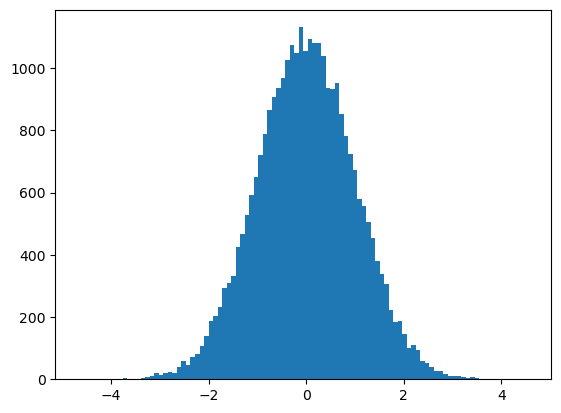

In [14]:
x = np.random.normal(0,1,size=(30000))
_ = plt.hist(x, bins=100)
print(stats.normaltest(x))

## compare statistics to subject rewards

In [15]:
reward_df = pd.read_pickle("trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

## grab subject stack

In [17]:
normal_tests = []
vars = []
means = []
for subject_idx, subject in enumerate(subjects):
    filtered_stack = subject_calibration_stacks[subject_idx]
    log_norms = np.log(np.linalg.norm(analysis.remove_nan_rows(filtered_stack.transpose(0,1,3,2).reshape(-1,64)),axis=1))
    normal_tests += [stats.normaltest(log_norms)]
    means += [np.mean(log_norms)]
    vars += [np.var(log_norms)]

Text(0, 0.5, 'Variance')

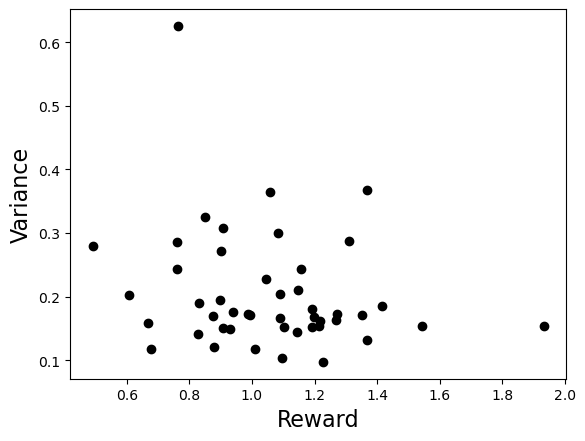

In [18]:
plt.plot(mean_rewards,vars,"ko")
plt.xlabel("Reward")
plt.ylabel("Variance")

Text(0, 0.5, 'Mean')

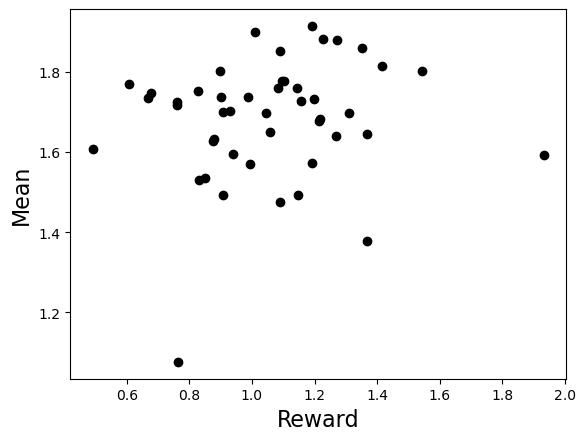

In [19]:
plt.plot(mean_rewards,means,"ko")
plt.xlabel("Reward")
plt.ylabel("Mean")

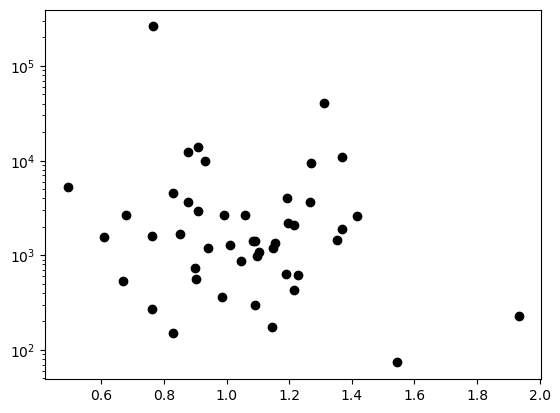

In [20]:
for i, (m, res) in enumerate(zip(mean_rewards,normal_tests)):
    stat = res.statistic
    p = res.pvalue
    plt.semilogy(m,stat,"ko")
    if p > 0.00001:
        print(i, stat, p)

(2400,)


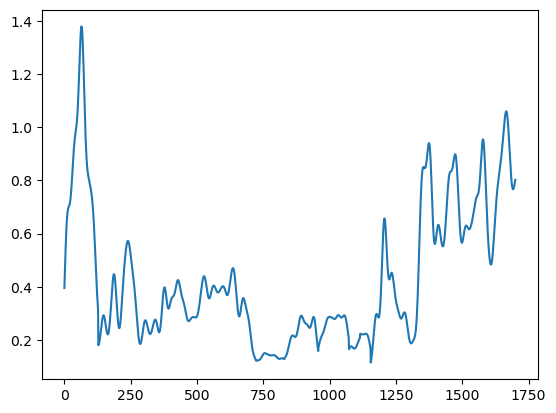

In [22]:
print(subject_calibration_stacks[0,0,0,2,:].shape)
plt.plot(subject_calibration_stacks[0,0,0,2,:])